In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

## Data Cleaning

In [3]:
df = pd.read_csv('./bank-full.csv', sep='\;')

/home/sravan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [4]:
df.head()

,"""age","""""job""""","""""marital""""","""""education""""","""""default""""","""""balance""""","""""housing""""","""""loan""""","""""contact""""","""""day""""","""""month""""","""""duration""""","""""campaign""""","""""pdays""""","""""previous""""","""""poutcome""""","""""y"""""""
0,"""58","""""management""""","""""married""""","""""tertiary""""","""""no""""",2143,"""""yes""""","""""no""""","""""unknown""""",5,"""""may""""",261,1,-1,0,"""""unknown""""","""""no"""""""
1,"""44","""""technician""""","""""single""""","""""secondary""""","""""no""""",29,"""""yes""""","""""no""""","""""unknown""""",5,"""""may""""",151,1,-1,0,"""""unknown""""","""""no"""""""
2,"""33","""""entrepreneur""""","""""married""""","""""secondary""""","""""no""""",2,"""""yes""""","""""yes""""","""""unknown""""",5,"""""may""""",76,1,-1,0,"""""unknown""""","""""no"""""""
3,"""47","""""blue-collar""""","""""married""""","""""unknown""""","""""no""""",1506,"""""yes""""","""""no""""","""""unknown""""",5,"""""may""""",92,1,-1,0,"""""unknown""""","""""no"""""""
4,"""33","""""unknown""""","""""single""""","""""unknown""""","""""no""""",1,"""""no""""","""""no""""","""""unknown""""",5,"""""may""""",198,1,-1,0,"""""unknown""""","""""no"""""""


In [5]:
df.columns = [i.replace('"', '') for i in df.columns]

In [6]:
for col in df.columns:
    try:
        df[col] = df[col].apply(lambda x: x.replace('\"',''))
        df[col] = pd.to_numeric(df[col])
    except:
        pass

In [7]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Missing Values

In [8]:
list(df.isna().sum())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Outlier Treatment

### Sanity checks

In [9]:
df.shape

(45211, 17)

In [10]:
# Age can't be negative or a very high number
df.age.min(), df.age.max()

(18, 95)

In [11]:
# Day number can't be less that 1 or greater than 31
df.day.min(), df.day.max()

(1, 31)

In [12]:
# Making sure day numbers don't exceed with respect to the months they're in
day = 29
for mon in ['feb','apr','jun','sep','nov']:
    
    if df.query('month=="{0} and day >{1}"'.format(mon, day)).shape[0] > 0:
        print(df.query('month=="{0} and day >{1}"'.format(mon, day)))
    day=30

In [13]:
# Making sure number of minutes in a call is a valid value
df.duration.min()/60, df.duration.max()/60

(0.0, 81.96666666666667)

In [14]:
# Shouldn't be any entries where a client has been contacted but number of days passed since last contact is -1
df.query('pdays!=-1 and previous==0')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y


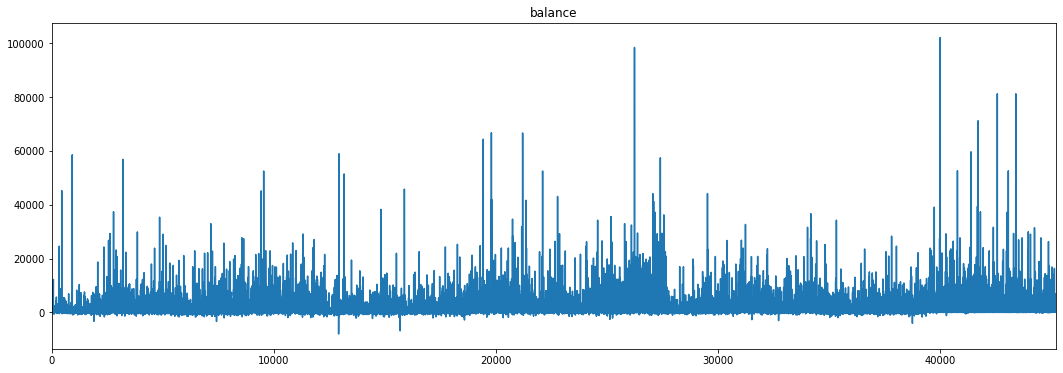

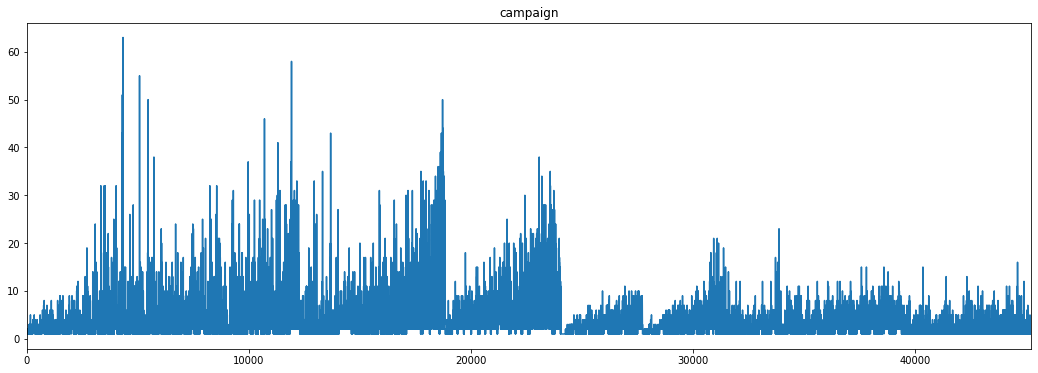

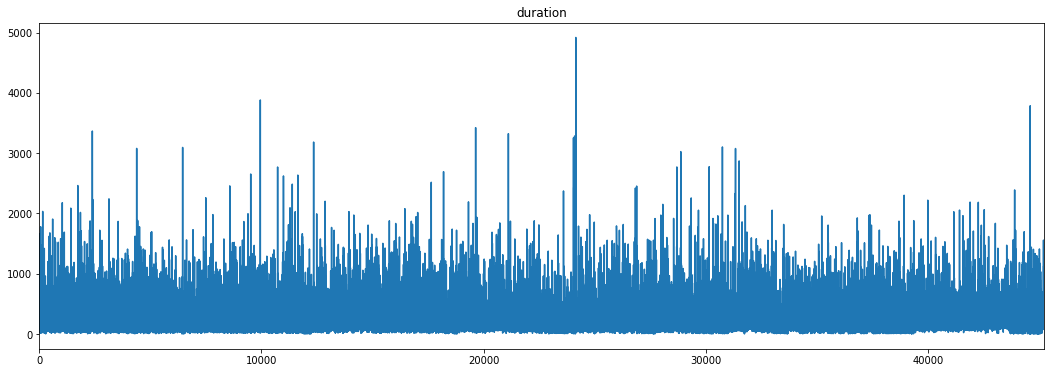

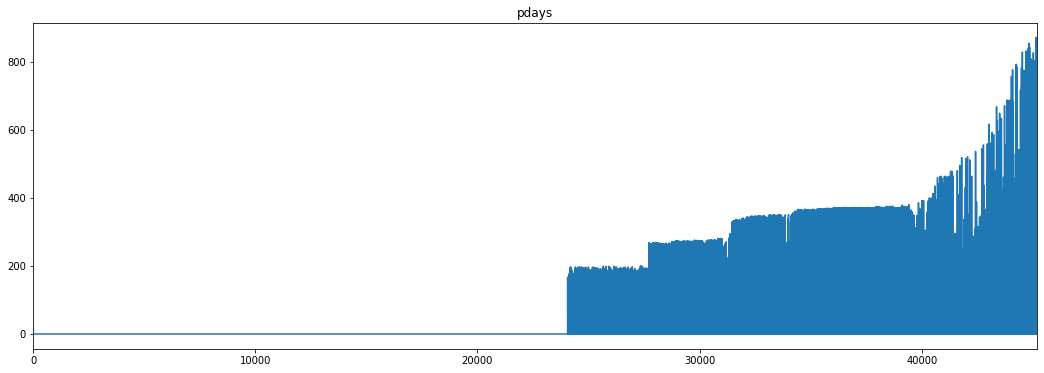

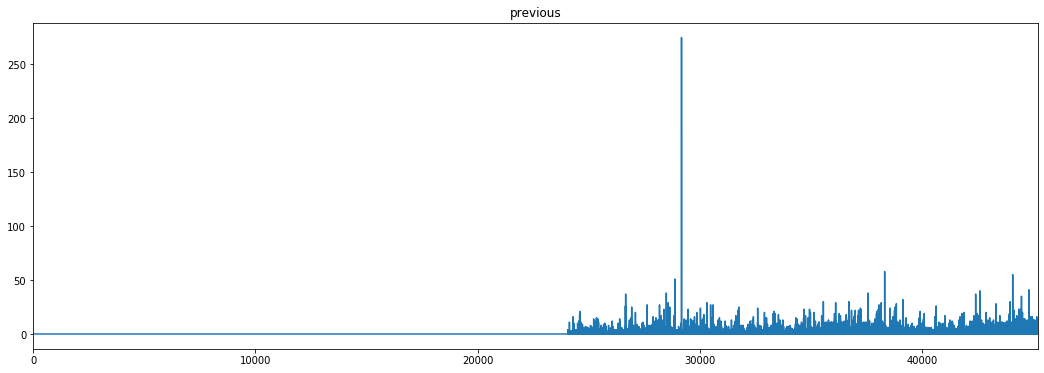

In [15]:
# Checking plots to see anything unusual
for col in ['balance','campaign','duration','pdays','previous']:
    plt.figure(figsize=(18,6))
    df[col].plot()
    plt.title('{}'.format(col))
    plt.show()

In [16]:
df.query('previous>100')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
29182,40,management,married,tertiary,no,543,yes,no,cellular,2,feb,349,2,262,275,other,no


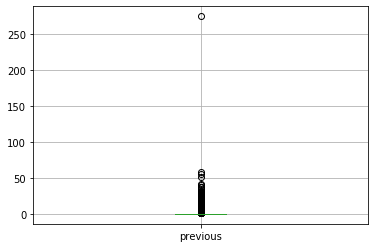

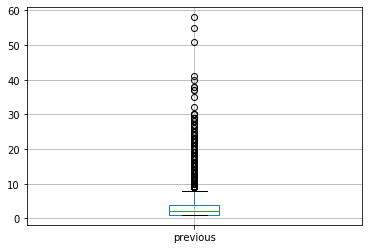

In [17]:
# Before removing
df.boxplot(['previous'])
plt.show()
# After removing
df.query('previous<100 and previous>0').boxplot(['previous'])
plt.show()

In [18]:
# Technically, 275 is a possible number of contacts performed but removing it anyway since all entry values are less than 60.
df = df.drop(29182)

In [19]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [20]:
# Checking distribution of class categories:
for col in ['job','marital','education','default','housing','loan','contact','month','poutcome','y']:
    print(df[col].value_counts(),'\n')

blue-collar      9732
management       9455
technician       7597
admin.           5169
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
admin               2
mgmt                2
Name: job, dtype: int64 

married     27213
single      12790
divorced     5207
Name: marital, dtype: int64 

secondary    23202
tertiary     13300
primary       6851
unknown       1857
Name: education, dtype: int64 

no     44395
yes      815
Name: default, dtype: int64 

yes    25129
no     20081
Name: housing, dtype: int64 

no     37966
yes     7244
Name: loan, dtype: int64 

cellular     29284
unknown      13020
telephone     2906
Name: contact, dtype: int64 

may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2648
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64 

unknown    36959
failure     4901
othe

__________________________________________________
Observation:
1. 'admin' and 'mgmt' only have 2 entries each in column job, should be taken care of.
2. There is a heavy class imbalance, needs to be addressed

## Feature Engineering

In [21]:
# admin and mgmt entries in job column:
df.job = df.job.apply(lambda x: 'admin' if x=='admin.' else x)
df.job = df.job.apply(lambda x: 'management' if x=='mgmt' else x)

In [22]:
# Class imbalance, making a copy entries with yes as target and doing a 40:60 split:
main_df = df.copy()
df = pd.concat([df.query('y=="yes"'), df])
df = pd.concat([df.query('y=="no"').sample(15000), df.query('y=="yes"')])

In [23]:
df.y.value_counts()

no     15000
yes    10578
Name: y, dtype: int64

### Numerical to categorical features

In [24]:
df.query('pdays>-1').shape

(6272, 17)

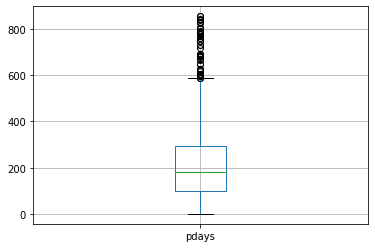

In [25]:
df.query('pdays>-1').boxplot(['pdays'])

100%|██████████| 854/854 [00:03<00:00, 270.08it/s]


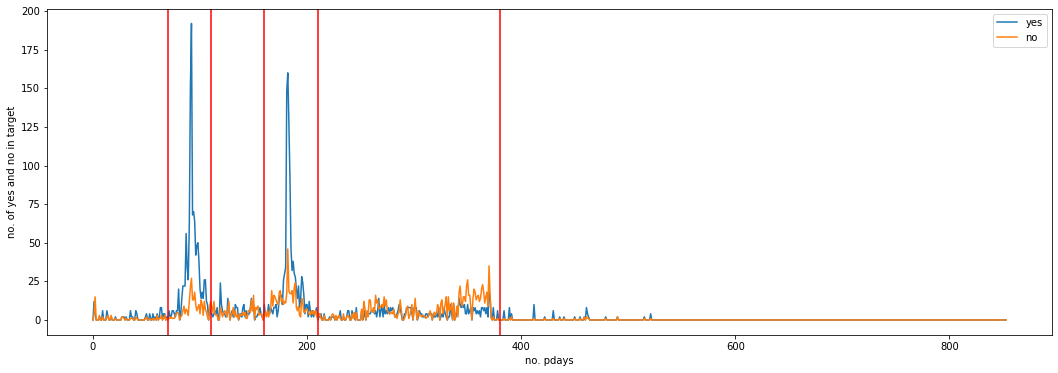

In [26]:
yes = []
no = []
for i in tqdm(range(df.pdays.max())):
    try:
        n = df.query('pdays=={}'.format(i)).y.value_counts()['no']
        y = df.query('pdays=={}'.format(i)).y.value_counts()['yes']
    except:
        y,n = (0,0)
    yes.append(y)
    no.append(n)

plt.figure(figsize=(18,6))
plt.plot(yes, label='yes')
plt.plot(no, label='no')
plt.axvline(x=70, color='r')
plt.axvline(x=110, color='r')
plt.axvline(x=160, color='r')
plt.axvline(x=210, color='r')
plt.axvline(x=380, color='r')
plt.xlabel('no. pdays')
plt.ylabel('no. of yes and no in target')
plt.legend()
plt.show()

In [27]:
# By doing this, we get rid of any entries with pdays = -1, so the model won't learn based on that
df['pdays_0_70'] = [1 if (i>-1 and i <=70) else 0 for i in df.pdays]
df['pdays_70_110'] = [1 if (i >70 and i<=110) else 0 for i in df.pdays]
df['pdays_110_160'] = [1 if (i >110 and i<=160) else 0 for i in df.pdays]
df['pdays_160_210'] = [1 if (i >160 and i<=210) else 0 for i in df.pdays]
df['pdays_210_380'] = [1 if (i >210 and i<=380) else 0 for i in df.pdays]
df['pdays_380'] = [1 if (i >380) else 0 for i in df.pdays]
df = df.drop(columns=['pdays'])

In [28]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,campaign,previous,poutcome,y,pdays_0_70,pdays_70_110,pdays_110_160,pdays_160_210,pdays_210_380,pdays_380
5423,33,blue-collar,married,secondary,no,745,yes,no,unknown,23,...,4,0,unknown,no,0,0,0,0,0,0
4186,52,entrepreneur,divorced,tertiary,no,81,yes,no,unknown,19,...,3,0,unknown,no,0,0,0,0,0,0
14940,32,housemaid,married,primary,no,91,yes,no,cellular,16,...,6,0,unknown,no,0,0,0,0,0,0
25336,33,technician,married,tertiary,no,17455,yes,yes,cellular,18,...,3,4,failure,no,0,0,0,1,0,0
8336,29,management,married,secondary,no,0,yes,no,unknown,2,...,4,0,unknown,no,0,0,0,0,0,0


### Boolean and categorical to numerical

In [29]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'previous',
       'poutcome', 'y', 'pdays_0_70', 'pdays_70_110', 'pdays_110_160',
       'pdays_160_210', 'pdays_210_380', 'pdays_380'],
      dtype='object')

In [30]:
df.default.unique(), df.housing.unique(), df.loan.unique(), df.y.unique()

(array(['no', 'yes'], dtype=object),
 array(['yes', 'no'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object))

In [31]:
df.default = df.default.apply(lambda x: 0 if x=='no' else 1)
df.housing = df.housing.apply(lambda x: 0 if x=='no' else 1)
df.loan = df.loan.apply(lambda x: 0 if x=='no' else 1)
df.y = df.y.apply(lambda x: 0 if x=='no' else 1)

months = np.array(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])
df.month = df.month.apply(lambda x: np.where(months==x)[0][0])

In [32]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,campaign,previous,poutcome,y,pdays_0_70,pdays_70_110,pdays_110_160,pdays_160_210,pdays_210_380,pdays_380
5423,33,blue-collar,married,secondary,0,745,1,0,unknown,23,...,4,0,unknown,0,0,0,0,0,0,0
4186,52,entrepreneur,divorced,tertiary,0,81,1,0,unknown,19,...,3,0,unknown,0,0,0,0,0,0,0
14940,32,housemaid,married,primary,0,91,1,0,cellular,16,...,6,0,unknown,0,0,0,0,0,0,0
25336,33,technician,married,tertiary,0,17455,1,1,cellular,18,...,3,4,failure,0,0,0,0,1,0,0
8336,29,management,married,secondary,0,0,1,0,unknown,2,...,4,0,unknown,0,0,0,0,0,0,0


In [33]:
np.sort(df.month.unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

### Categorical

In [34]:
df.job.unique(), df.marital.unique(), df.education.unique(), df.contact.unique(), df.poutcome.unique()

(array(['blue-collar', 'entrepreneur', 'housemaid', 'technician',
        'management', 'retired', 'self-employed', 'services', 'student',
        'admin', 'unknown', 'unemployed'], dtype=object),
 array(['married', 'divorced', 'single'], dtype=object),
 array(['secondary', 'tertiary', 'primary', 'unknown'], dtype=object),
 array(['unknown', 'cellular', 'telephone'], dtype=object),
 array(['unknown', 'failure', 'other', 'success'], dtype=object))

In [35]:
df = pd.get_dummies(df, columns=['job', 'marital', 'education', 'contact', 'poutcome'])

In [36]:
# Dropping all unknown columns since we don't want the model to be biased w.r.t the unknown categories
df = df.drop(columns=['job_unknown', 'education_unknown', 'contact_unknown', 'poutcome_unknown'])

In [37]:
df.head()

,age,default,balance,housing,loan,day,month,duration,campaign,previous,...,marital_married,marital_single,education_primary,education_secondary,education_tertiary,contact_cellular,contact_telephone,poutcome_failure,poutcome_other,poutcome_success
5423,33,0,745,1,0,23,4,115,4,0,...,1,0,0,1,0,0,0,0,0,0
4186,52,0,81,1,0,19,4,214,3,0,...,0,0,0,0,1,0,0,0,0,0
14940,32,0,91,1,0,16,6,110,6,0,...,1,0,1,0,0,1,0,0,0,0
25336,33,0,17455,1,1,18,10,168,3,4,...,1,0,0,0,1,1,0,1,0,0
8336,29,0,0,1,0,2,5,85,4,0,...,1,0,0,1,0,0,0,0,0,0


## Training Random Forest

In [38]:
train, test = train_test_split(df, test_size=0.3)#question 8 split 70:30

In [39]:
y_train = train.y
x_train = train.drop(columns=['y'])
y_test = test.y
x_test = test.drop(columns=['y'])

In [40]:
rfmod = RandomForestClassifier()
rfmod.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [41]:
rfmod.score(x_train, y_train), rfmod.score(x_test, y_test)

(0.9999441465594281, 0.9093041438623924)

#### Train accuracy: 99.9%   ; Test accuracy: 90.9%

Checking the removed rows too:

In [42]:
# By doing this, we get rid of any entries with pdays = -1, so the model won't learn based on that
main_df['pdays_0_70'] = [1 if (i>-1 and i <=70) else 0 for i in main_df.pdays]
main_df['pdays_70_110'] = [1 if (i >70 and i<=110) else 0 for i in main_df.pdays]
main_df['pdays_110_160'] = [1 if (i >110 and i<=160) else 0 for i in main_df.pdays]
main_df['pdays_160_210'] = [1 if (i >160 and i<=210) else 0 for i in main_df.pdays]
main_df['pdays_210_380'] = [1 if (i >210 and i<=380) else 0 for i in main_df.pdays]
main_df['pdays_380'] = [1 if (i >380) else 0 for i in main_df.pdays]
main_df = main_df.drop(columns=['pdays'])

In [43]:
main_df.default = main_df.default.apply(lambda x: 0 if x=='no' else 1)
main_df.housing = main_df.housing.apply(lambda x: 0 if x=='no' else 1)
main_df.loan = main_df.loan.apply(lambda x: 0 if x=='no' else 1)
main_df.y = main_df.y.apply(lambda x: 0 if x=='no' else 1)

months = np.array(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])
main_df.month = main_df.month.apply(lambda x: np.where(months==x)[0][0])

In [44]:
main_df = pd.get_dummies(main_df, columns=['job', 'marital', 'education', 'contact', 'poutcome'])

In [45]:
# Dropping all unknown columns since we don't want the model to be biased w.r.t the unknown categories
main_df = main_df.drop(columns=['job_unknown', 'education_unknown', 'contact_unknown', 'poutcome_unknown'])

In [46]:
# Removing rows already in df:
rowstoremove = np.intersect1d(main_df.index, df.index)
main_df = main_df.drop(rowstoremove)

In [47]:
# Sanity check
main_df.shape[0] + df.shape[0] - df.query('y==1').shape[0]/2

45210.0

In [48]:
y = main_df.y
x = main_df.drop(columns=['y'])

In [49]:
rfmod.score(x, y)

0.8870249227435084

#### Accuracy on remaining entries with target  'no' : 88.7%

## Neural network

Ideally neural net isn't the best idea for such small number of features 

In [50]:
from keras import Sequential, Input
from keras.layers import Dense

Using TensorFlow backend.


In [51]:
model = Sequential()
model.add(Dense(128, input_dim=38))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'RMSProp', loss='binary_crossentropy', metrics=['accuracy'])

In [52]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               4992      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 29,825
Trainable params: 29,825
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.fit(x_train,y_train, epochs=20, validation_data=(x_test, y_test))

Train on 17904 samples, validate on 7674 samples
Epoch 1/20
17904/17904 [==============================] - 3s 184us/step - loss: 7.7519 - accuracy: 0.6136 - val_loss: 3.5307 - val_accuracy: 0.6938
Epoch 2/20
17904/17904 [==============================] - 3s 141us/step - loss: 1.1797 - accuracy: 0.6724 - val_loss: 0.5539 - val_accuracy: 0.7154
Epoch 3/20
17904/17904 [==============================] - 2s 130us/step - loss: 0.6901 - accuracy: 0.6992 - val_loss: 0.5365 - val_accuracy: 0.7402
Epoch 4/20
17904/17904 [==============================] - 2s 123us/step - loss: 0.8877 - accuracy: 0.7003 - val_loss: 0.9303 - val_accuracy: 0.7464
Epoch 5/20
17904/17904 [==============================] - 2s 111us/step - loss: 0.6830 - accuracy: 0.7136 - val_loss: 0.5070 - val_accuracy: 0.7501
Epoch 6/20
17904/17904 [==============================] - 2s 130us/step - loss: 0.7011 - accuracy: 0.7186 - val_loss: 1.6849 - val_accuracy: 0.7198
Epoch 7/20
17904/17904 [==============================] - 2s 13

We see the neural net is performing as well but since it was mentioned in the assignment that accuracy isn't important, we move on to deploying our model.

#### Saving RF model and nn model:

In [54]:
model.save('./nn.h5')

In [55]:
import pickle
file = open('./rfmod.pkl','wb')
pickle.dump(rfmod, file)